## Today i want to train a CNN to classify images of legends from the game Brawlhalla
To do this I am using my own dataset of Brawlhalla legends. The dataset it filled with images taken directly from the game. I have done thid before with SVM. but i thought it would be interesting to see if i can improve the accuracy making use of a neural network.

This notebook is split up in 3 parts
- [Legend Classification with CNN (only in-game images)](#Legend-Classification-with-CNN(only-in-game-images-dataset))
- [Legend Classification with CNN (in-game images + art)](#Legend-Classification-with-CNN(ingame-images-+-Art))

<h1 style="text-align:center;background-color:yellow;font-size:50px;"><br><br><br>Legend Classification with CNN<br>(only in-game images dataset)<br><br><br>

## Import Dependencies

In [15]:
# TensorFlow and tf.keras
import tensorflow as tf # 2.13.0
import sys # Python 3.10.12
import PIL # 10.1.0
import sklearn as sk # 1.3.1
 
from PIL import Image
from sklearn.model_selection import train_test_split

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
import copy
import math
from pathlib import Path

print(tf.__version__)
print(sys.version)
print(PIL.__version__)
print(sk.__version__)

2.13.0
3.10.12 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 19:01:18) [MSC v.1916 64 bit (AMD64)]
10.1.0
1.3.1


## Import my Custom Brawlhalla Legend Dataset
important to note: i renamed the classes to have a number in front of them. so bodvar became 0-bodvar. this is done because strings are not suported as labels.

In [16]:
ROOT_DIR = 'brawlhalla-data-legends'

def get_sub_dirs(root_dir):
    classes = []
    for root_dir, dirs, files in os.walk(root_dir):
        if len(dirs) > 0:
            classes = dirs
    return classes


classes = get_sub_dirs(ROOT_DIR)
print(f'classes found {len(classes)}:')
for c in classes:
    print(c)

classes found 4:
0-bodvar
1-cassidy
2-lord-Vraxx
3-orion


## Load in the Images

In [17]:
# Variables
SIZE = 128
class_names = get_sub_dirs(ROOT_DIR)

# hardcoded
legend_images = [0, 0, 0, 0] # Zero's represent images per legend (following legend order in game) -> Bodvar, Cassidy, Orion, Vraxx

# Functions

# there should be a way to remove the hardcoding here
def count_images_per_class(folder_name):
    if class_names[0] in str(folder_name):
        legend_images[0] += 1
    if class_names[1] in str(folder_name):
        legend_images[1] += 1
    if class_names[2] in str(folder_name):
        legend_images[2] += 1
    if class_names[3] in str(folder_name):
        legend_images[3] += 1

def load_image(file, SIZE):
    img = Image.open(file)
    img = img.resize((SIZE, SIZE))
    return np.array(img).flatten()

def load_labelled_images(path, SIZE):
    labels = list()
    files = list()
    for file_info in [x for x in Path(path).glob("**/*.jpg")]:
        labels.append(int(file_info.parts[1][0:1]))
        files.append(str(file_info))
        count_images_per_class(file_info)
        
    imgs = np.array([load_image(f, SIZE) for f in files])
    return imgs, np.array(labels)      

# Load all images to the notebook
images, labels = load_labelled_images(ROOT_DIR, SIZE)
print("Loaded", len(images), "images in the following", len(np.unique(labels)), "classes:")

for label, image in zip(np.unique(labels), legend_images):
    print(f'{label} ({image})')

Loaded 147 images in the following 4 classes:
0 (32)
1 (44)
2 (39)
3 (32)


## Reshaping the images in my dataset 
for some reason they have a shape of (49152,)

0


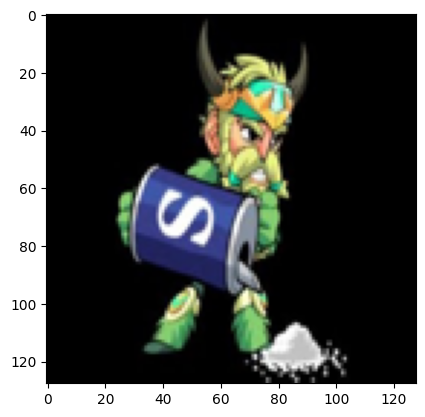

In [18]:
print(labels[0]) # 0 = bodvar (0-bodvar)
images = images.reshape(len(images), SIZE, SIZE, 3)
plt.imshow(images[0])

## Checking out the data

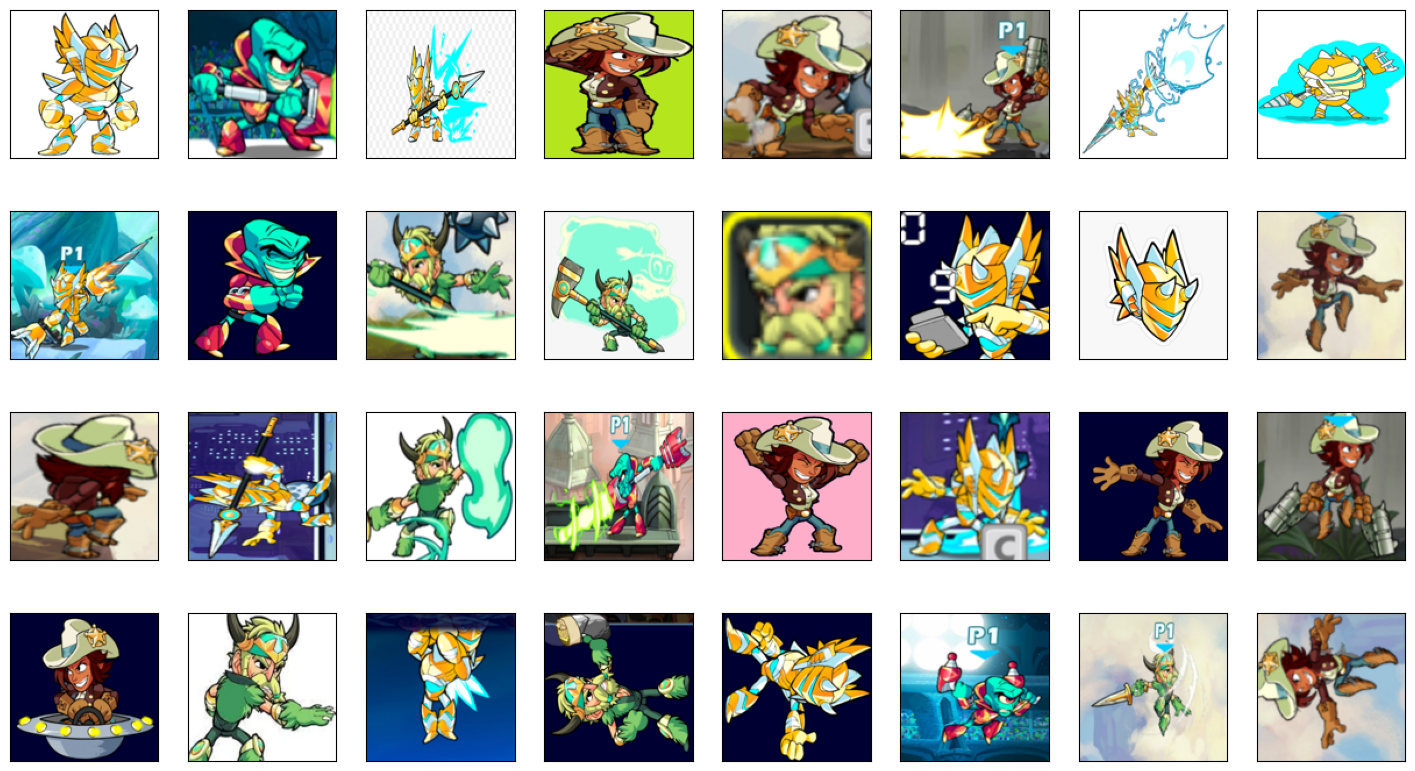

In [19]:
sample_size = 32

plotimgs = copy.deepcopy(images)
np.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(np.reshape(x, [SIZE, SIZE, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

the labels are now numbers instead of strings

In [20]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


## Split images in train and test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.2)

#X_train
y_test

array([2, 0, 3, 3, 1, 2, 2, 2, 1, 0, 3, 1, 1, 0, 1, 3, 2, 0, 3, 3, 3, 2,
       0, 2, 3, 1, 2, 3, 2, 3])

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the [*layer*](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


### Feed the model

To start training,  call the [`model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method—so called because it "fits" the model to the training data:

In [24]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
4/4 [==============================] - 1s 55ms/step - loss: 6035.4731 - accuracy: 0.2222
Epoch 2/10
4/4 [==============================] - 0s 41ms/step - loss: 6030.4331 - accuracy: 0.2222
Epoch 3/10
4/4 [==============================] - 0s 44ms/step - loss: 4938.8218 - accuracy: 0.2735
Epoch 4/10
4/4 [==============================] - 0s 44ms/step - loss: 4325.8008 - accuracy: 0.4188
Epoch 5/10
4/4 [==============================] - 0s 44ms/step - loss: 5342.9160 - accuracy: 0.3248
Epoch 6/10
4/4 [==============================] - 0s 56ms/step - loss: 2575.1050 - accuracy: 0.4786
Epoch 7/10
4/4 [==============================] - 0s 50ms/step - loss: 1444.7574 - accuracy: 0.4359
Epoch 8/10
4/4 [==============================] - 0s 49ms/step - loss: 1347.7660 - accuracy: 0.6239
Epoch 9/10
4/4 [==============================] - 0s 51ms/step - loss: 615.1628 - accuracy: 0.7607
Epoch 10/10
4/4 [==============================] - 0s 53ms/step - loss: 542.4335 - accuracy: 0.7009


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [25]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 931.5359 - accuracy: 0.4333 - 144ms/epoch - 144ms/step

Test accuracy: 0.4333333373069763


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [26]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [27]:
predictions = probability_model.predict(X_test)

1/1 [==============================] - 0s 92ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [28]:
predictions[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [29]:
np.argmax(predictions[0])

2

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [30]:
y_test[0]

2

Define functions to graph the full set of 10 class predictions.

In [31]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

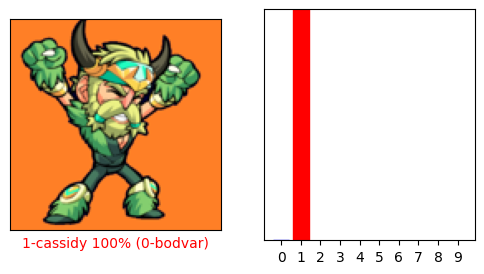

In [130]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

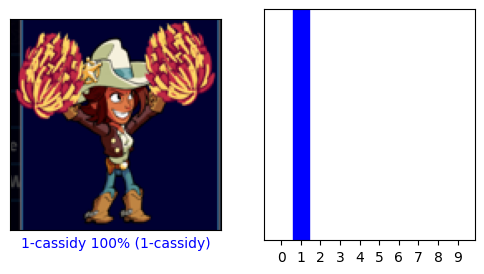

In [131]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

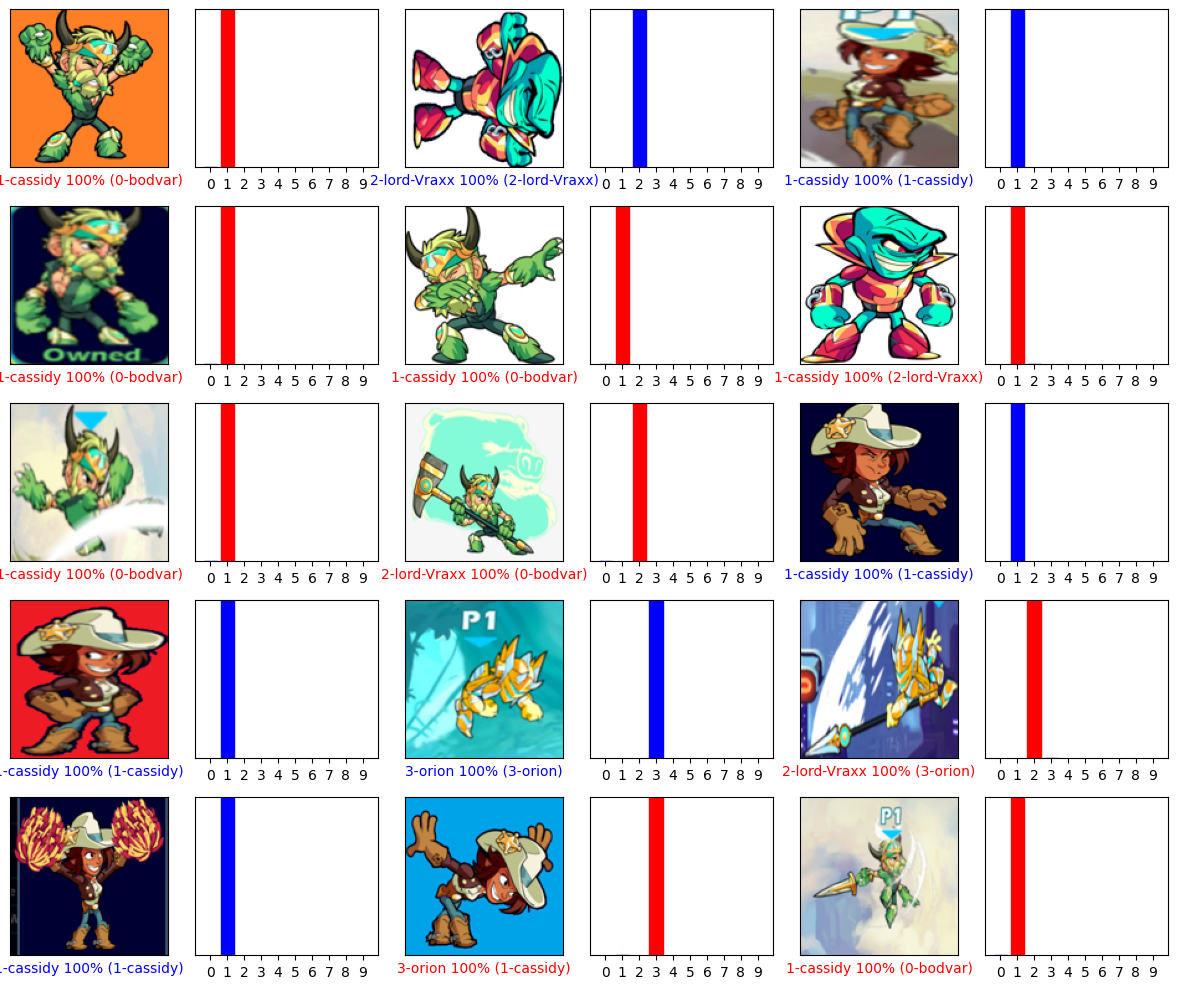

In [132]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

my conclusion to the low accuracy is the low amount of data

accuracies
- SVM (kNN): 61%
- Linear: 58%
- CNN: 50%

I do have other datasets. Currently we have used the dataset with only ingame images. but i have 3 custom datasets

datasets
- **ingame images only** < current
- legend art only
- both datasets mixed

SVM got worse results on the mixed dataset. I do feel like a CNN might possibly get a better accuracy since i think it can better understand harder connections. lets just try it

<h1 style="text-align:center;background-color:yellow;font-size:50px;"><br></b><br><br>Legend Classification with CNN<br>(ingame images + Art)<br><br><br>

*Note: this dataset will be reffered to as mixed dataset*

## Load in images

In [146]:
ROOT_DIR = 'brawlhalla-data-mixed'


classes = get_sub_dirs(ROOT_DIR)
print(f'classes found {len(classes)}:')
for c in classes:
    print(c)
print()

# Variables
SIZE = 128
class_names = get_sub_dirs(ROOT_DIR)

# hardcoded
legend_images = [0, 0, 0, 0] # Zero's represent images per legend (following legend order in game) -> Bodvar, Cassidy, Orion, Vraxx   

# Load all images to the notebook
images, labels = load_labelled_images(ROOT_DIR, SIZE)
print("Loaded", len(images), "images in the following", len(np.unique(labels)), "classes:")
for label, image in zip(np.unique(labels), legend_images):
    print(f'{label} ({image})')


classes found 4:
0-Bodvar
1-Cassidy
2-Lord-Vraxx
3-Orion

Loaded 288 images in the following 4 classes:
0 (69)
1 (77)
2 (74)
3 (68)


## Reshape Images

In [148]:
# reshape images
images = images.reshape(len(images), SIZE, SIZE, 3)

## Sample Images

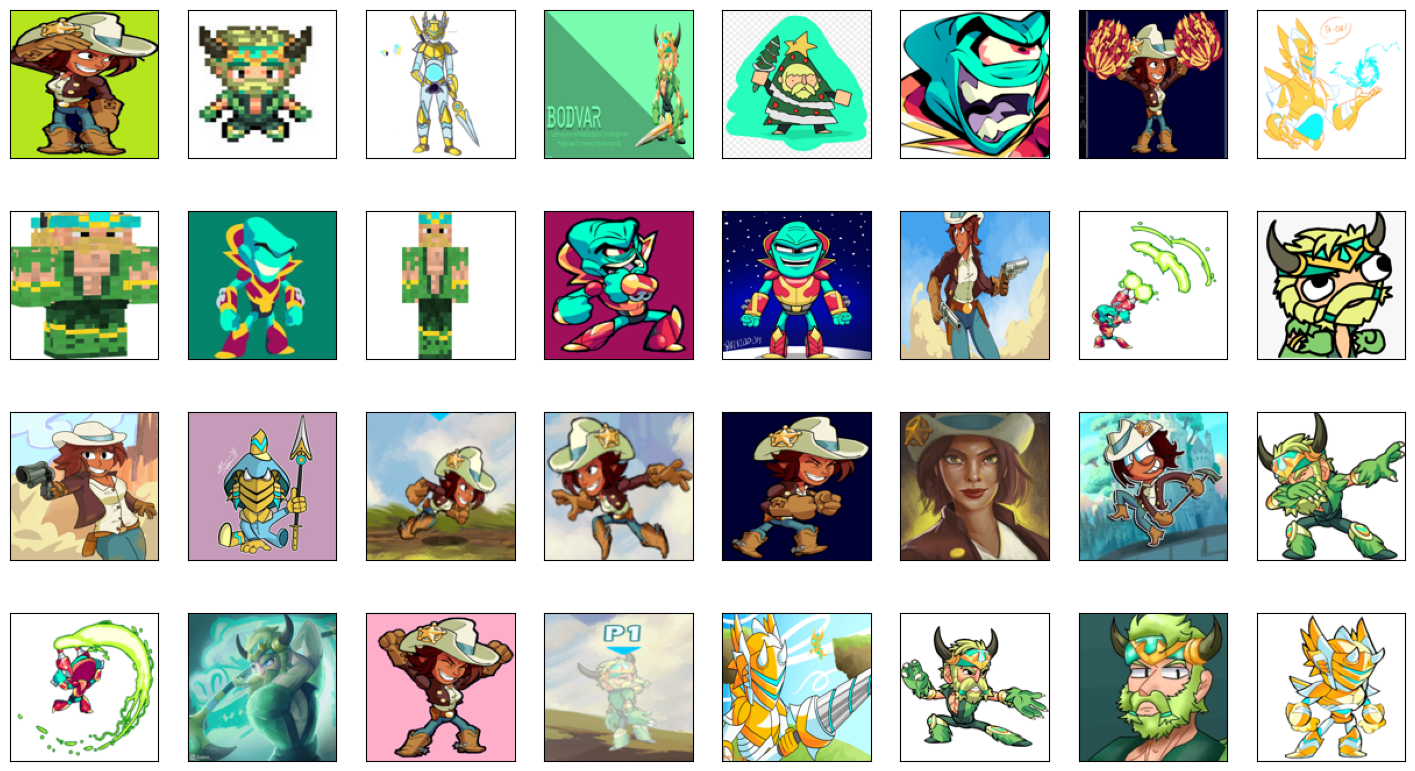

In [150]:
sample_size = 32

plotimgs = copy.deepcopy(images)
np.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(np.reshape(x, [SIZE, SIZE, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

## Train Test Split

In [165]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3)

#X_train
y_test

array([1, 2, 2, 3, 2, 0, 1, 0, 2, 1, 1, 1, 3, 3, 0, 0, 1, 0, 0, 1, 1, 2,
       0, 1, 0, 1, 2, 2, 0])

## Build Model

In [169]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)

Epoch 1/10
9/9 [==============================] - 1s 57ms/step - loss: 9480.2998 - accuracy: 0.2124
Epoch 2/10
9/9 [==============================] - 0s 52ms/step - loss: 6976.4004 - accuracy: 0.3243
Epoch 3/10
9/9 [==============================] - 0s 55ms/step - loss: 3340.3823 - accuracy: 0.3784
Epoch 4/10
9/9 [==============================] - 1s 59ms/step - loss: 2091.9045 - accuracy: 0.3900
Epoch 5/10
9/9 [==============================] - 0s 53ms/step - loss: 1546.3125 - accuracy: 0.5251
Epoch 6/10
9/9 [==============================] - 1s 56ms/step - loss: 1292.7651 - accuracy: 0.5676
Epoch 7/10
9/9 [==============================] - 0s 54ms/step - loss: 572.3733 - accuracy: 0.6332
Epoch 8/10
9/9 [==============================] - 0s 52ms/step - loss: 354.6333 - accuracy: 0.7375
Epoch 9/10
9/9 [==============================] - 0s 55ms/step - loss: 345.3111 - accuracy: 0.7722
Epoch 10/10
9/9 [==============================] - 0s 51ms/step - loss: 659.2202 - accuracy: 0.6564


In [170]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

1/1 - 0s - loss: 2653.2192 - accuracy: 0.3448 - 144ms/epoch - 144ms/step

Test accuracy: 0.3448275923728943


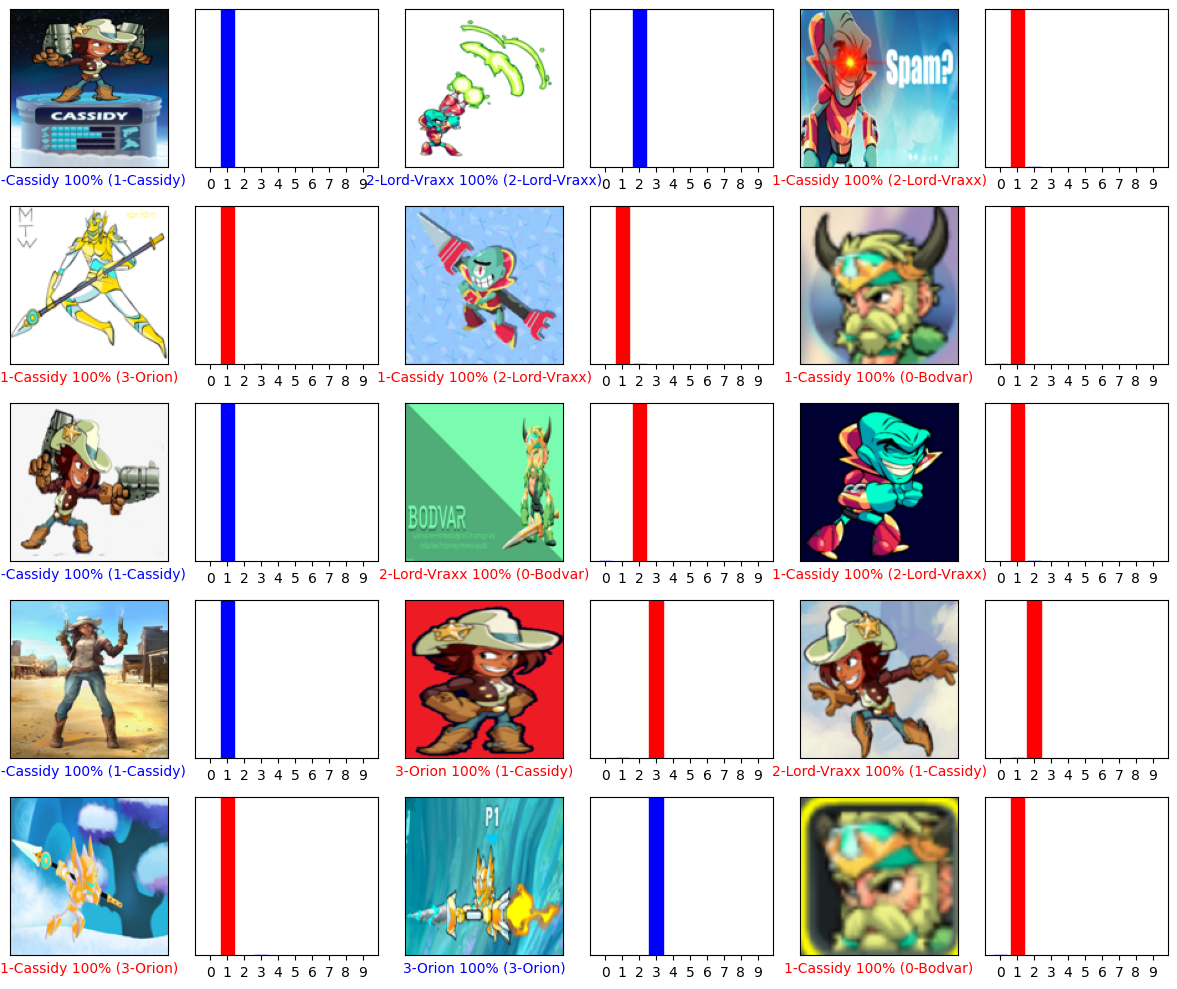

In [171]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

hahahahha terrible accuracy

accuracies
- SVM kNN: 61%
- Linear: 58%
- CNN ( in-game dataset | 80% train / 20% test | 10 epochs ): 50%
- CNN ( mixed dataset | 80% train / 20% test | 10 epochs ): 44%
- CNN ( mixed dataset | 90% train / 10% test | 10 epochs ): 41%
- CNN ( mixed dataset | 90% train / 10% test | 100 epochs ): 34%
- CNN ( mixed dataset | 90% train / 10% test | 5 epochs ): 38%
- CNN ( mixed dataset | 70% train / 30% test | 10 epochs ): 34%

I supose the dataset just has too few entries. I wonder what you think about it

<h1 style="text-align:center;background-color:yellow;font-size:40px;"><br></b><br><br>Legend Classification with CNN and Transfer Learning<br>(ingame images)<br><br><br>

## Load in Images

In [49]:
ROOT_DIR = 'brawlhalla-data-legends'


classes = get_sub_dirs(ROOT_DIR)
print(f'classes found {len(classes)}:')
for c in classes:
    print(c)
print()

# Variables
SIZE = 128
class_names = get_sub_dirs(ROOT_DIR)

# hardcoded
legend_images = [0, 0, 0, 0] # Zero's represent images per legend (following legend order in game) -> Bodvar, Cassidy, Orion, Vraxx   

# Load all images to the notebook
images, labels = load_labelled_images(ROOT_DIR, SIZE)
print("Loaded", len(images), "images in the following", len(np.unique(labels)), "classes:")
for label, image in zip(np.unique(labels), legend_images):
    print(f'{label} ({image})')


classes found 4:
0-bodvar
1-cassidy
2-lord-Vraxx
3-orion

Loaded 147 images in the following 4 classes:
0 (32)
1 (44)
2 (39)
3 (32)


## Reshape Images

In [50]:
# reshape images
images = images.reshape(len(images), SIZE, SIZE, 3)

## Sample Images

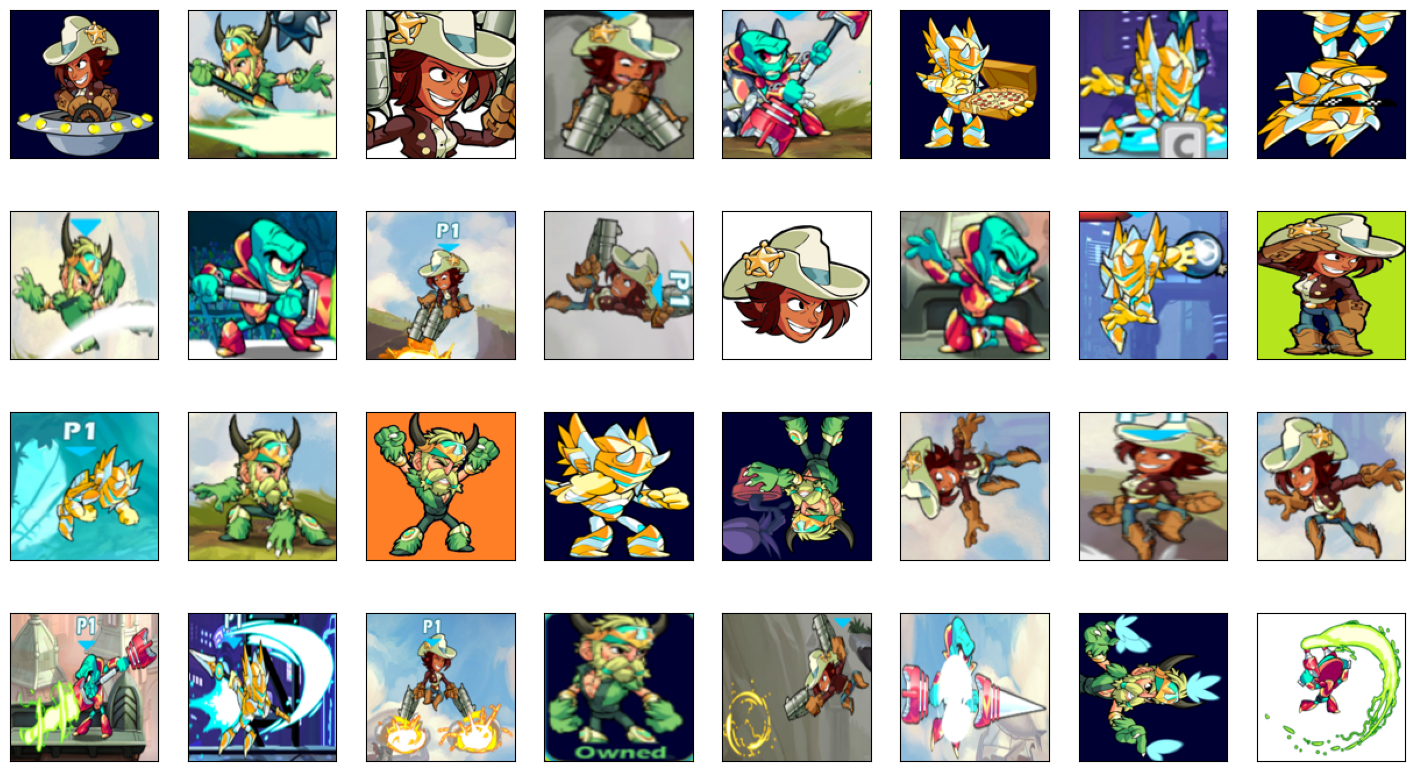

In [51]:
sample_size = 32

plotimgs = copy.deepcopy(images)
np.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(np.reshape(x, [SIZE, SIZE, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

## Train Test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.2)

#X_train
y_test

array([0, 0, 2, 0, 1, 2, 1, 1, 0, 2, 2, 0, 0, 3, 1, 3, 1, 0, 1, 1, 1, 2,
       2, 1, 1, 1, 2, 3, 0, 2])

## Load Model - VGG16

In [75]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

base_model = MobileNet(input_shape = (128, 128, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')




for layer in base_model.layers:
    layer.trainable = False




# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

## Train Model

In [76]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
4/4 [==============================] - 2s 140ms/step - loss: -11.8760 - acc: 0.2650
Epoch 2/10
4/4 [==============================] - 1s 129ms/step - loss: -33.3704 - acc: 0.2821
Epoch 3/10
4/4 [==============================] - 1s 137ms/step - loss: -50.1301 - acc: 0.2821
Epoch 4/10
4/4 [==============================] - 1s 136ms/step - loss: -65.1981 - acc: 0.2821
Epoch 5/10
4/4 [==============================] - 1s 148ms/step - loss: -77.3341 - acc: 0.2821
Epoch 6/10
4/4 [==============================] - 1s 136ms/step - loss: -92.8769 - acc: 0.2821
Epoch 7/10
4/4 [==============================] - 1s 135ms/step - loss: -97.5393 - acc: 0.2821
Epoch 8/10
4/4 [==============================] - 1s 140ms/step - loss: -113.1095 - acc: 0.2821
Epoch 9/10
4/4 [==============================] - 1s 135ms/step - loss: -126.6798 - acc: 0.2821
Epoch 10/10
4/4 [==============================] - 1s 131ms/step - loss: -145.7670 - acc: 0.2821


## Test Model

In [77]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

1/1 - 1s - loss: -5.3971e+01 - acc: 0.3667 - 528ms/epoch - 528ms/step

Test accuracy: 0.36666667461395264


## Evaluate

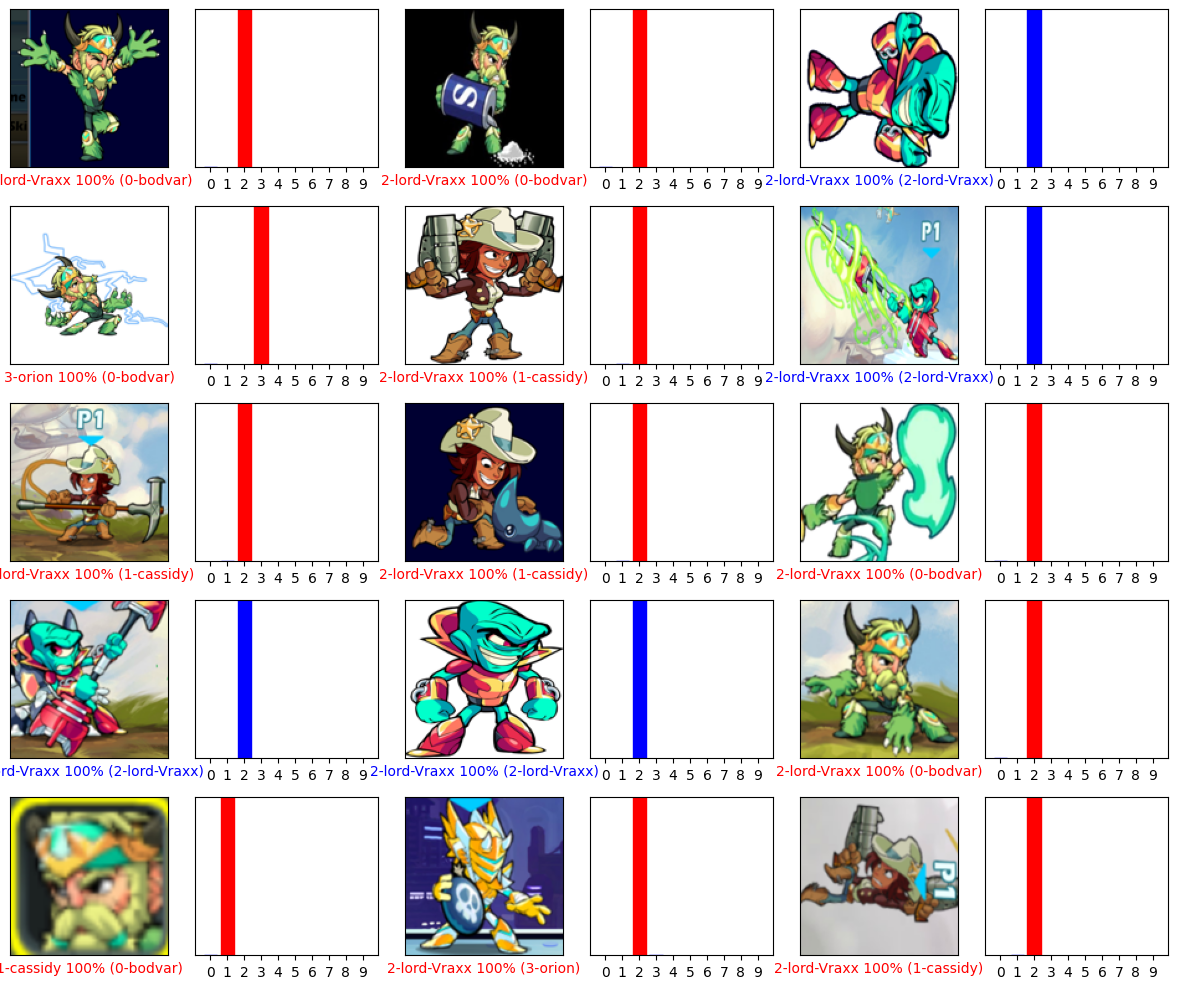

In [68]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

accuracies
```
- SVM kNN: 61%
- Linear: 58%
- CNN (                                        in-game dataset | 80% train / 20% test | 10 epochs ): 50%
- CNN (                                          mixed dataset | 80% train / 20% test | 10 epochs ): 44%
- CNN (                                          mixed dataset | 90% train / 10% test | 10 epochs ): 41%
- CNN (                                          mixed dataset | 90% train / 10% test | 100 epochs): 34%
- CNN (                                          mixed dataset | 90% train / 10% test | 5 epochs  ): 38%
- CNN (                                          mixed dataset | 70% train / 30% test | 10 epochs ): 34%
- CNN + Transfer Learning ( model=VGG16      | in-game dataset | 80% train / 20% test | 10 epochs ): 37%
- CNN + Transfer Learning ( model=VGG16      | in-game dataset | 80% train / 20% test | 100 epochs): 37%
- CNN + Transfer Learning ( model=MobileNet  | in-game dataset | 80% train / 20% test | 10 epochs ): 37%
- CNN + Transfer Learning ( model=ResNet50V2 | in-game dataset | 80% train / 20% test | 10 epochs ): 37%
```

For some reason whenever i use transfer learning, the accuracy is always: 0.36666667461395264

idk why